In [9]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ntutemnist/emnist-byclass-train.npz
/kaggle/input/ntutemnist/emnist-byclass-test.npz
/kaggle/input/ntutemnist/pred_results_example.csv
/kaggle/input/ntutemnist/simple_nn_train.ipynb


In [10]:
import os
for dirname, _, filenames in os.walk('/kaggle/working'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Import Libraries

In [11]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import timm
import cv2
import torch.optim as optim
import torchvision.models as models
import torchvision
import math
import torch.nn.functional as F

from PIL import Image
from tqdm.notebook import tqdm
from sklearn import model_selection, metrics
from torch.utils.data import DataLoader
from tqdm import tqdm
from transformers import ViTModel
from torch.optim.lr_scheduler import StepLR
from transformers import ViTForImageClassification, ViTConfig
from statistics import mean
from keras.utils import plot_model

plt.style.use('fivethirtyeight')

Load Dataset

In [12]:
data = np.load('/kaggle/input/ntutemnist/emnist-byclass-train.npz')
labels = data['training_labels']
images = data['training_images']

test_images = np.load('/kaggle/input/ntutemnist/emnist-byclass-test.npz')['testing_images']

In [13]:
len(labels), len(images)

(697932, 697932)

In [14]:
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')
use_cuda, device

(True, device(type='cuda'))

Show some images

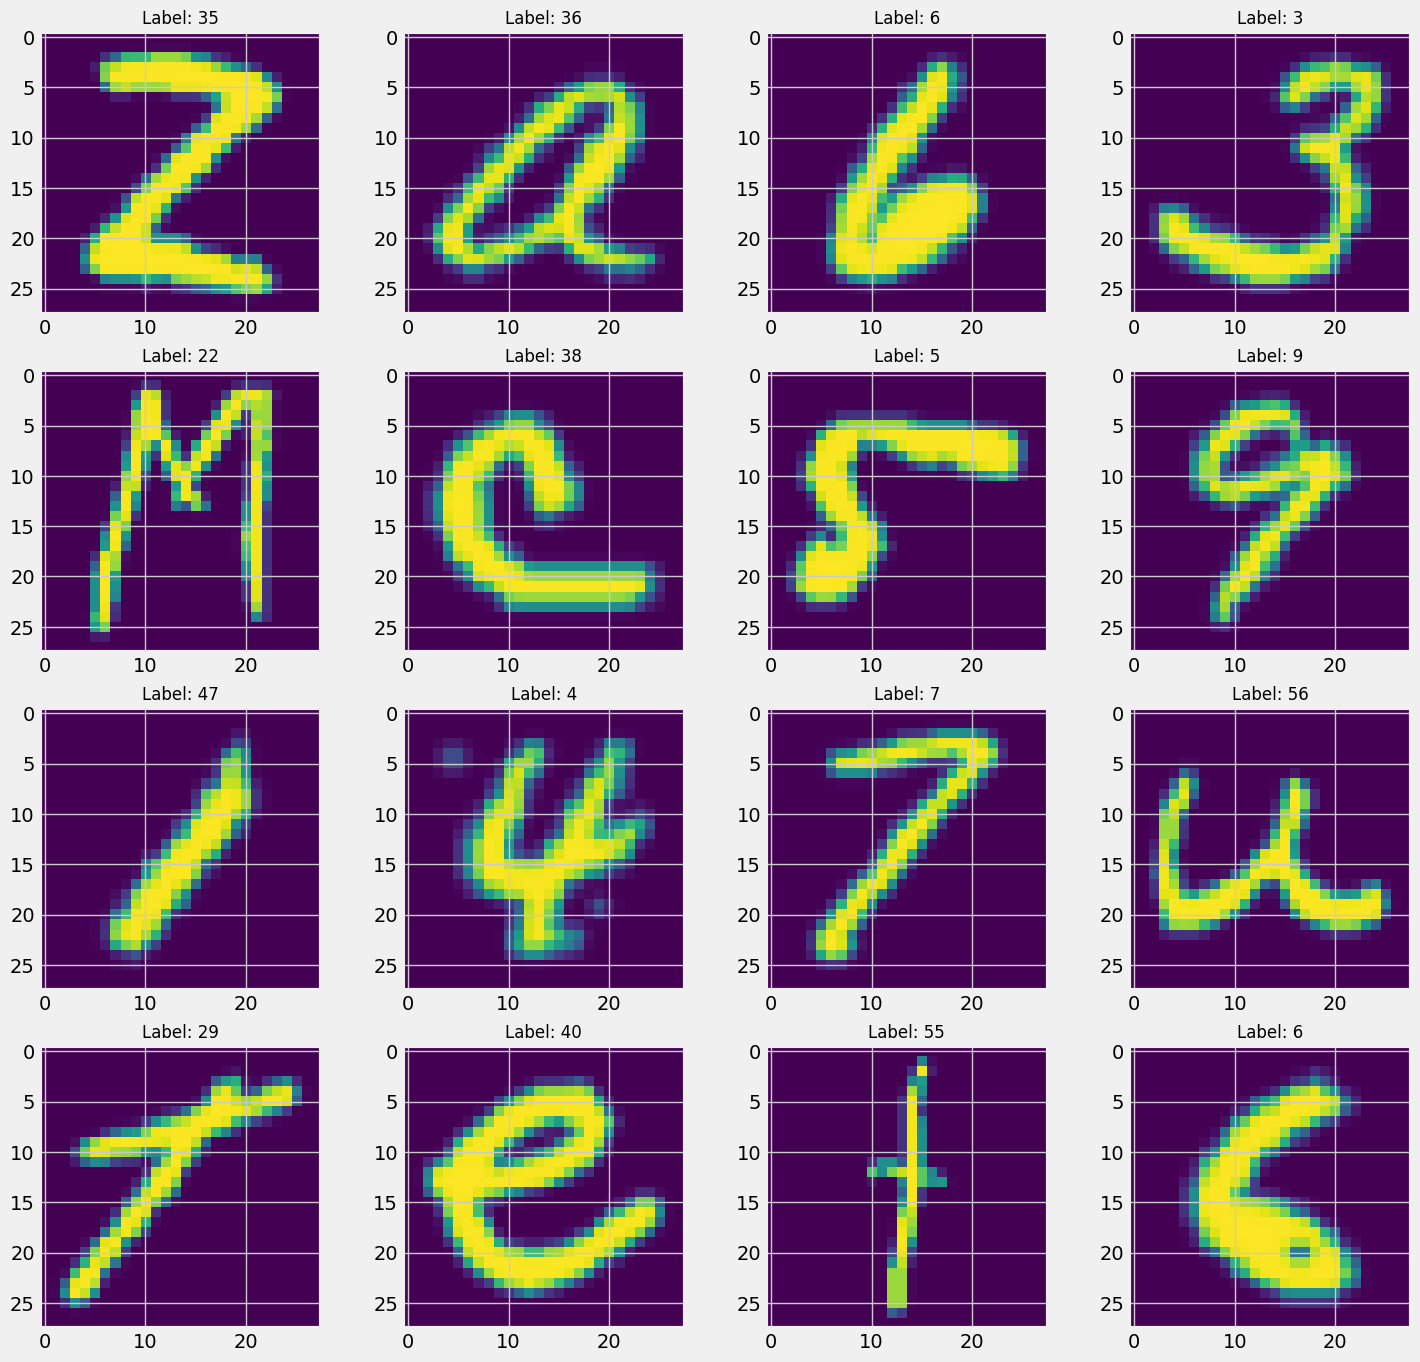

In [15]:
plt.figure(figsize=(16, 16))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(images[i])
    plt.title(f'Label: {int(labels[i])}', fontsize=12)
plt.show()

In [16]:
IMG_SIZE = 28
BATCH_SIZE = 48
LR = 0.00001
EPOCHS = 5
NUM_CLASSES = 62

Split dataset

In [17]:
train_len = int(len(images) * 0.87)
train_images = images[:train_len]
val_images = images[train_len:]
train_labels = labels[:train_len]
val_labels = labels[train_len:]

len(train_images), len(val_images), len(train_labels), len(val_labels)

(607200, 90732, 607200, 90732)

Rewrite dataset class

In [18]:
class MnistDataset(torch.utils.data.Dataset):
    
    def __init__(self, df_images, df_labels, transforms=None):
        super().__init__()
        self.images = df_images
        self.labels = df_labels
        self.transforms = transforms 
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        img = self.images[index]
        label = int(self.labels[index])
        
        if self.transforms is not None:
            img = self.transforms(img)
            
        return img, label

Data Augmentation

In [19]:
transforms_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomPerspective(),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomRotation(10, fill=(0,)),
    transforms.Normalize((0.1307,), (0.3081,))
])

transforms_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.Normalize((0.1307,), (0.3081,))
])

In [20]:
train_dataset = MnistDataset(df_images=train_images, df_labels=train_labels, transforms=transforms_train)
val_dataset = MnistDataset(df_images=val_images, df_labels=val_labels, transforms=transforms_val)

In [21]:
len(train_dataset), len(val_dataset)

(607200, 90732)

In [22]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE)

Define SpinalVGG Model

In [23]:
Half_width = 256
layer_width = 128 

class SpinalVGG(nn.Module):  

    def two_conv_pool(self, in_channels, f1, f2):
        s = nn.Sequential(
            nn.Conv2d(in_channels, f1, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(f1),
            nn.ReLU(inplace=True),
            nn.Conv2d(f1, f2, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(f2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        for m in s.children():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
        return s
    
    def three_conv_pool(self,in_channels, f1, f2, f3):
        s = nn.Sequential(
            nn.Conv2d(in_channels, f1, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(f1),
            nn.ReLU(inplace=True),
            nn.Conv2d(f1, f2, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(f2),
            nn.ReLU(inplace=True),
            nn.Conv2d(f2, f3, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(f3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        for m in s.children():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
        
        return s

    def __init__(self, num_classes=62):
        super(SpinalVGG, self).__init__()
        self.l1 = self.two_conv_pool(1, 64, 64)
        self.l2 = self.two_conv_pool(64, 128, 128)
        self.l3 = self.three_conv_pool(128, 256, 256, 256)
        self.l4 = self.three_conv_pool(256, 256, 256, 256)  
        self.dropout = nn.Dropout(p = 0.2)       
        self.fc_spinal_layer1 = nn.Sequential(
              nn.Linear(Half_width, layer_width),
              nn.ReLU(inplace=True)
        )
        self.fc_spinal_layer2 = nn.Sequential(
              nn.Linear(Half_width + layer_width * 1, layer_width),
              nn.ReLU(inplace=True)
        )
        self.fc_spinal_layer3 = nn.Sequential(
              nn.Linear(Half_width + layer_width * 2, layer_width),
              nn.ReLU(inplace=True)
        )
        self.fc_spinal_layer4 = nn.Sequential(
              nn.Linear(Half_width + layer_width * 3, layer_width),
              nn.ReLU(inplace=True)
        )
        self.fc_out = nn.Sequential(
              nn.Linear(Half_width + layer_width*4, num_classes)
        )
        
    
    def forward(self, x):
        x = self.l1(x)
        x = self.l2(x)
        x = self.l3(x)
        x = self.l4(x)
        x = x.view(x.size(0), -1)
        Xaux = self.dropout(x)
        x1 = self.fc_spinal_layer1(x)
        Xaux = torch.cat([Xaux,x1], dim=1)
        x2 = self.fc_spinal_layer2(Xaux)
        Xaux = torch.cat([Xaux,x2], dim=1)
        x3 = self.fc_spinal_layer3(Xaux)
        Xaux = torch.cat([Xaux,x3], dim=1)
        x4 = self.fc_spinal_layer4(Xaux)
        Xaux = torch.cat([Xaux,x4], dim=1)
        x= self.fc_out(Xaux)
        return F.log_softmax(x, dim=1)

In [24]:
model = SpinalVGG().to(device)
# model = ModelM7().to(device)
# model = torch.load('/kaggle/working/model5.pkl').to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR) 
scheduler = StepLR(optimizer, step_size=6, gamma=0.5)

def update_lr(optimizer, lr):    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
        
curr_lr = LR

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/working/model5.pkl'

Train Model

In [ ]:
train_losses = [] 
val_losses = []
train_accs = []
val_accs = []

def train():
    
    best_acc = 0
    best_acc_index = 1

    for epoch in range(EPOCHS):

        total_acc_train = 0
        total_loss_train = 0
        model.train()

        for i, (inputs, targets) in enumerate(train_dataloader):

            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)

            batch_loss = criterion(outputs, targets)
            total_loss_train += batch_loss

            _, preds = torch.max(outputs, 1)
            total_acc_train += (preds == targets.data).sum()

            optimizer.zero_grad()
            batch_loss.backward()

            optimizer.step()

            if (i + 1) % 1000 == 0:
                print('Epoch [%2d/%2d], Step [%3d/%3d], Batch_Loss: %.4f' % (epoch + 1, EPOCHS, i + 1, len(train_dataset) // BATCH_SIZE, batch_loss.item()))

        scheduler.step()
        model.eval()
        total_acc_val = 0
        total_loss_val = 0

        with torch.no_grad():
            for i, (inputs, targets) in enumerate(val_dataloader):
                val_loss = []

                inputs = inputs.to(device)
                targets = targets.to(device)

                outputs = model(inputs)

                batch_loss = criterion(outputs, targets)
                total_loss_val += batch_loss

                _, preds = torch.max(outputs, 1)
                total_acc_val += (preds == targets.data).sum()

        print(f'Epoch {epoch + 1}  :  Epoch_train_accuracy: {total_acc_train / len(train_dataset)}%', f' Epoch_val_accuracy: {total_acc_val / len(val_dataset)}')

        train_losses.append(total_loss_train / len(train_dataset))
        train_accs.append(total_acc_train / len(train_dataset))
        val_losses.append(total_loss_val / len(val_dataset))
        val_accs.append(total_acc_val / len(val_dataset))
        
        if (total_acc_val / len(val_dataset)) >= best_acc:
            best_acc = total_acc_val / len(val_dataset)
            best_acc_index = epoch + 1
            torch.save(model, f'model{best_acc_index}.pkl')
            
        if (total_acc_val / len(val_dataset)) < 0.2:
            break
            
    return best_acc_index
        
best_acc_index = train()

Plot

In [ ]:
train_losses_list = []
for value in train_losses:
    num = value.detach().cpu().numpy()
    train_losses_list.append(num)

val_losses_list = []
for value in val_losses:
    num = value.detach().cpu().numpy()
    val_losses_list.append(num)
    
train_accs_list = []
for value in train_accs:
    num = value.detach().cpu().numpy()
    train_accs_list.append(num)

val_accs_list = []
for value in val_accs:
    num = value.detach().cpu().numpy()
    val_accs_list.append(num)

In [ ]:
plt.figure(figsize=(18, 6))

plt.plot(
    train_losses_list, 
    label='Train_Losses', 
    color='red', 
    linewidth=1.5
)
plt.plot(
    val_losses_list, 
    label='Val_Losses', 
    color='blue', 
    linewidth=1.5
)

plt.plot(
    train_accs_list, 
    label='Train_Accuracy', 
    color='green', 
    linewidth=1.5
)
plt.plot(
    val_accs_list, 
    label='Val_Accuracy', 
    color='pink', 
    linewidth=1.5
)

plt.xlabel('Epoch')
plt.ylabel('Loss / Accuracy')
plt.title('Loss / Accuracy on train / validation')
plt.legend()
plt.show()

Test dataset

In [ ]:
sub_df = pd.read_csv('/kaggle/input/ntutemnist/pred_results_example.csv')
len(sub_df), len(test_images)

In [ ]:
sub_df.head()

In [ ]:
test_labels = sub_df['Category']

In [ ]:
test_dataset = MnistDataset(df_images=test_images, df_labels=test_labels, transforms=transforms_val)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

Predict

In [ ]:
final_preds = []

def predict(model, dataloader, device):
    model = torch.load(f'model{best_acc_index}.pkl')
    model.eval()
    
    with torch.no_grad():
        for inputs, targets in tqdm(dataloader):
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            outputs = model(inputs)
            
            _, preds = torch.max(outputs, 1)
            preds = preds.cpu().data.numpy()
            
            final_preds.extend(preds)
            
predict(model, test_dataloader, device)

len(final_preds)

In [ ]:
sub_df['Category'] = final_preds
sub_df.to_csv('submission.csv', index=False)